In [3]:
# imports
import sys

sys.path.append('../')
from connection import create_spotify_oauth, get_audio_features, get_token, get_tracks, \
    tracks_to_df, audio_features_to_df, get_artist_info, artist_info_to_df, get_album_info, \
        album_info_to_df, get_similar_artists

from itertools import chain

import json
import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, Normalizer
from sklearn.feature_extraction.text import FeatureHasher

In [2]:
# token and authentication variables

sp_ouath = create_spotify_oauth()
token_info = get_token()

In [3]:
# getting playlist items

playlist_source = '5tsD40JmH6fgIrguJdJ8tk' # playlist id for playlist

# playlists id's to play around with: 
### 5a4unKpRA7mYi2PAgKTuNW
### 7jfRuO7rW49RJnafrxsJeu
### 2YWkEfOW4TG0njIeLqFk4B
### 02dSgnwgoovYRH6RlptgDC
### 5EGXIeHfAZjPh1YeVLyG13
### 5tsD40JmH6fgIrguJdJ8tk
###

tracks = get_tracks(playlist_source, token_info) # parses Spotipy.playlist_items() to fetch playlist items
tracks_df = tracks_to_df(tracks) # extracts relevant features from messy list into a df

# drops duplicate songs based on track ID, this is useful if a song gets added from single and 
# album release; or in the case of deluxe versions of albums, etc.
tracks_df.drop_duplicates(subset=['track_id'], inplace=True)

In [4]:
# getting tracks' features

tracks_features = []

for track in tracks_df['track_id']:
    track_af = get_audio_features(track, token_info) # parses Spotipy.audio_features() to fetch track features
    tracks_features.extend(track_af) # extends each track's features into the empty list init'd before
    
tracks_features_df = audio_features_to_df(tracks_features) # converts nested data from API call to simple df


In [5]:
# getting tracks' artists

tracks_artists = []

for artist_id in tracks_df['artist_id']:
    for i in artist_id: # since one track can have multiple artists, loop over the list of artists to pull data for each one
        artist_info = get_artist_info(i, token_info)
        tracks_artists.append(artist_info)

artists_df = artist_info_to_df(tracks_artists) # converts nested data to df

In [6]:
# getting tracks' albums

tracks_albums = []

for album_id in tracks_df['album_id']:
    album_info = get_album_info(album_id, token_info)
    tracks_albums.append(album_info)

albums_df = album_info_to_df(tracks_albums) # converts nested data to df

In [7]:
# processing tracks dataframe

# merging features df to track df
tracks_df.drop(['album_cover_640', 'album_cover_300', 'album_cover_64'], axis=1, inplace=True)
tracks_df = pd.merge(tracks_df, tracks_features_df, how='left')

tracks_df = tracks_df.explode('artist_id') 

# binarizing explicit column
tracks_df['explicit'] = tracks_df['explicit'].replace({True: 1, False: 0})

In [8]:
# processing artists dataframe

# lambda converts the columns into strings and strips of the exterior [] and '' using re, then splits the string 
# into a list based on ','
artists_df['artist_genres'] = artists_df['artist_genres'].apply(lambda x: re.sub(r"[\[\]']", '', str(x)).split(','))

# unnest the list of genres into seperate rows, rest of features are duplicated
artists_df = artists_df.explode('artist_genres')

# creates a copy of artist_df where there are no genres then drops those rows from the original df
artists_missing_genres = artists_df.loc[artists_df['artist_genres'] == ""].copy()
artists_df = artists_df[artists_df['artist_genres'] != '']

# check for any artists that have missing genres
if not artists_df.loc[artists_df['artist_genres'] == ''].empty:
    
    # iterates through the rows of the dataframe
    for index, artist in artists_missing_genres.iterrows():
        artist_id = artist['artist_id']
        similar_artists = get_similar_artists(artist_id, token_info) # API call
        
        # list comprehension that fetches the artist genres for every similar artist    
        genres_list = [similar_artist['genres'] for similar_artist in similar_artists if similar_artist['genres']]
        
    # convert the loop output to list
    flattened_genres = list(chain.from_iterable(genres_list))

    # converting to set so only unique values remain in list and adding it to the artists_missing_genres df
    artists_missing_genres.at[index, 'artist_genres'] = list(set(flattened_genres)) 

    artists_missing_genres = artists_missing_genres.explode('artist_genres')

    # if after imputation, there are still no genres, mark it off as not imputable
    artists_missing_genres['artist_genres'].replace('','genre not imputable', inplace=True)

    # concat the missing artist genres with the original df
    artists_df = pd.concat([artists_df, artists_missing_genres], ignore_index=False)

# dropping  duplicate records, this occurs if a playlist has multiple tracks from the same artist
artists_df.drop_duplicates(subset=['artist_id', 'artist_genres'], inplace=True)

# wrapping the genres in lists (for feature hashing)
artists_df['artist_genres'] = artists_df['artist_genres'].apply(lambda x: ''.join(x)).apply(lambda x: [x])

In [9]:
# processing albums dataframe

# converting object type column to datetime
albums_df['album_release_date'] = pd.to_datetime(albums_df['album_release_date'], format="mixed")
albums_df['album_release_date'] = albums_df['album_release_date'].dt.year # keeping only YYYY info

# categorizing album type column
albums_df['album_type'] = albums_df['album_type'].replace({'single': 0, 'album': 1, 'compilation': 2}) # EP's count as singles

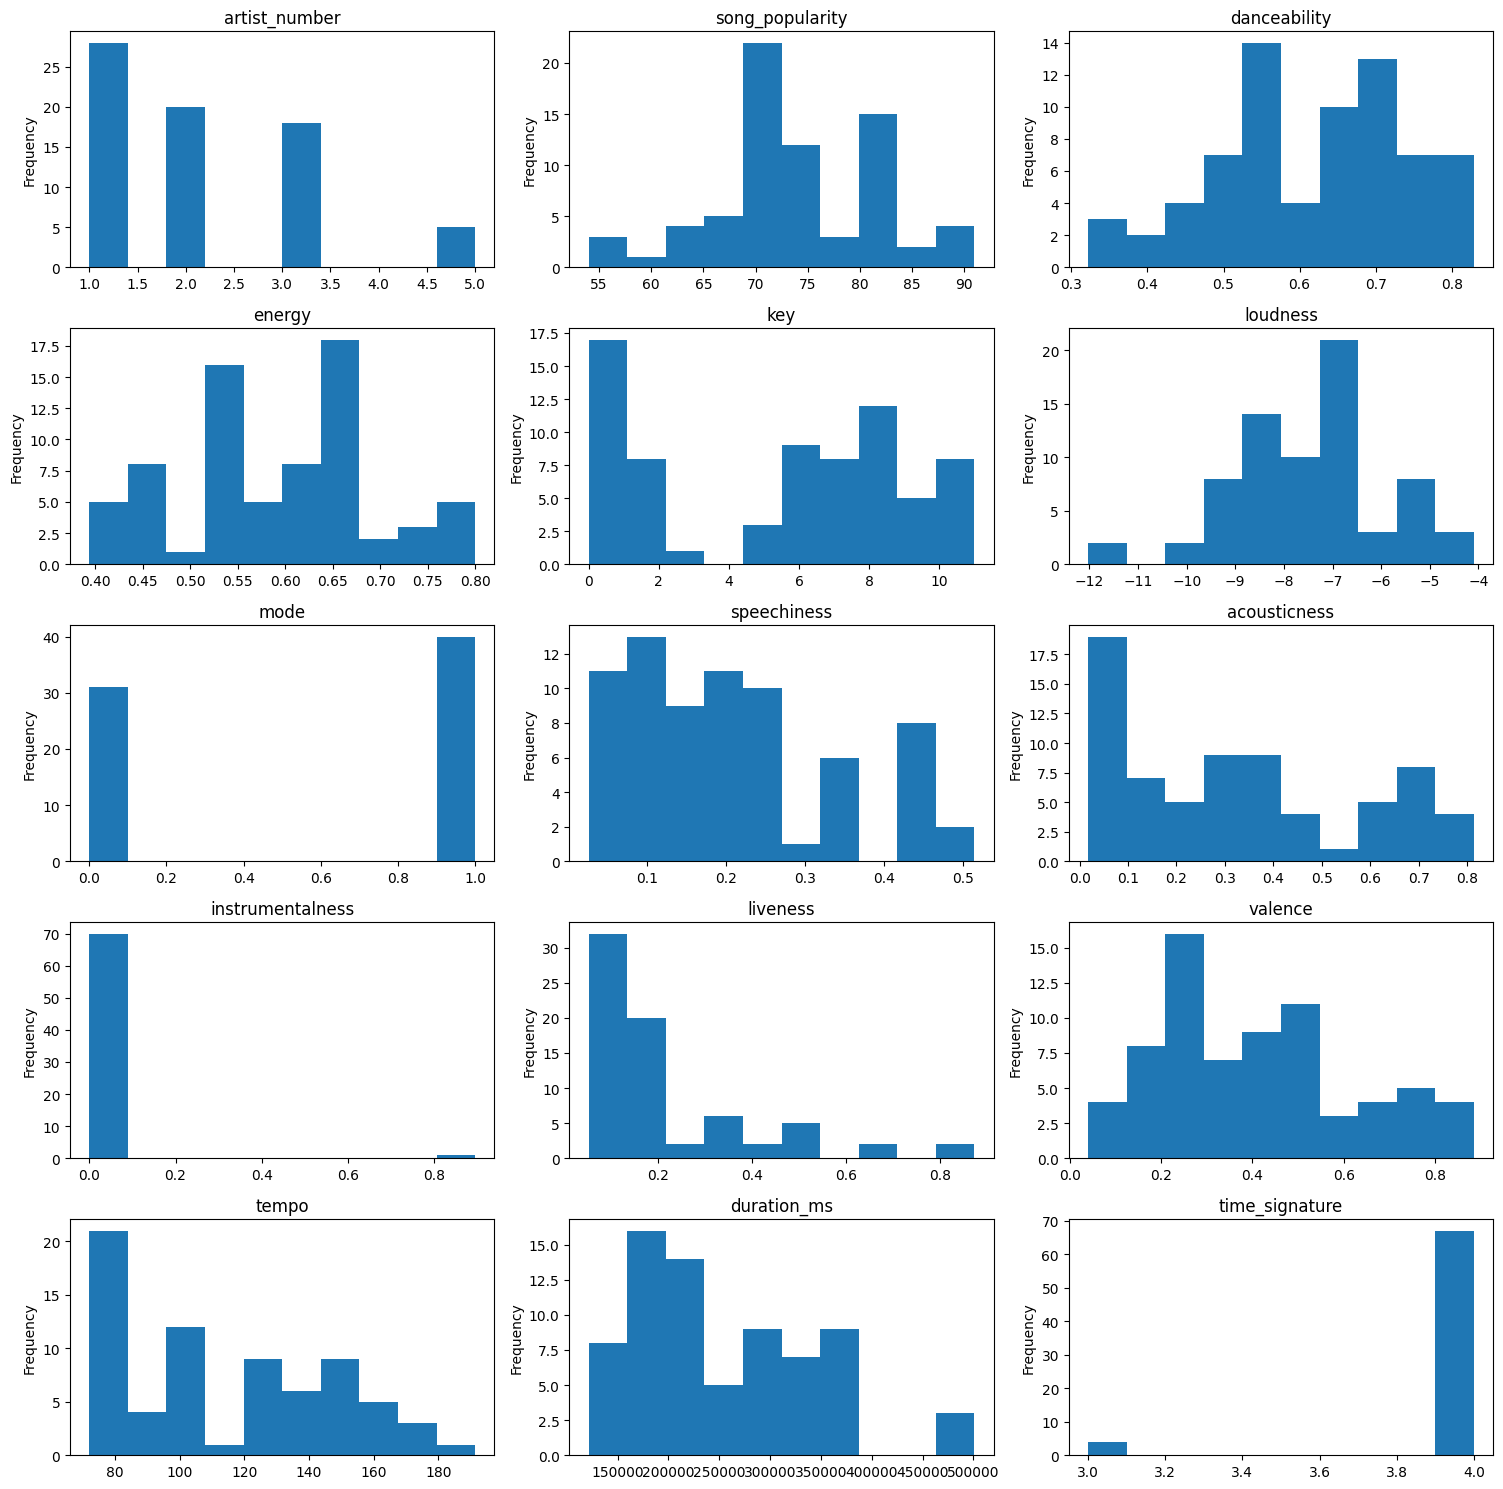

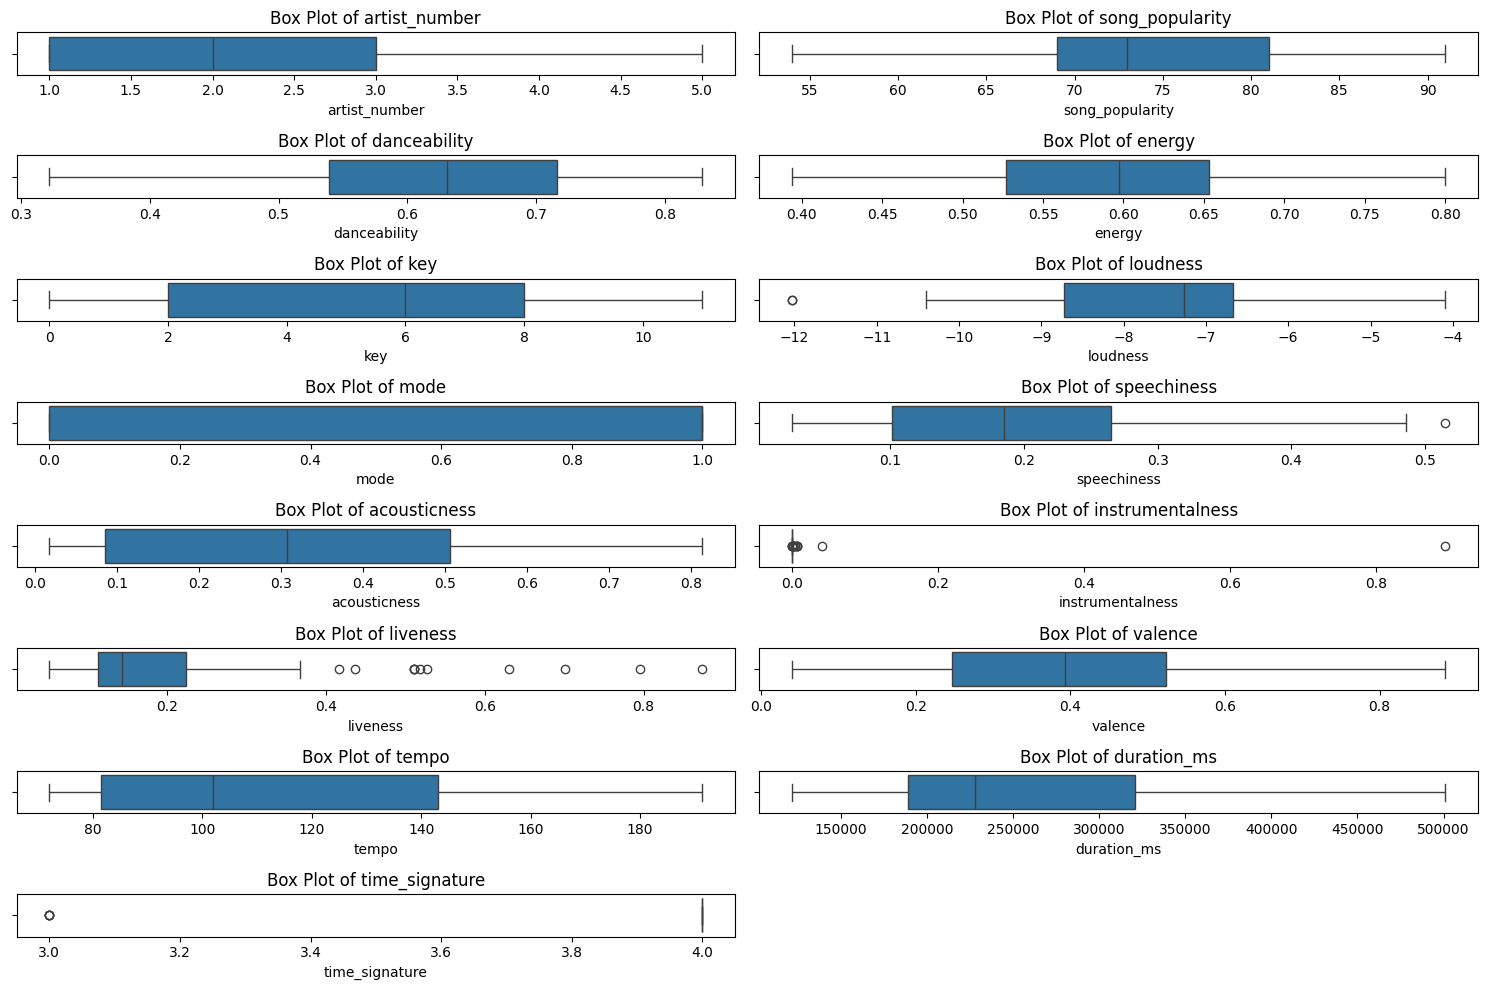

In [10]:
# tracks_df visualizations

# numerical features to plot 
tracks_cols_to_plot = ['artist_number', 'song_popularity', 'danceability', 'energy',
                'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
                'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

# histogram visualizations of numerical track_df features
num_cols = 3
num_rows = len(tracks_cols_to_plot) // num_cols + (len(tracks_cols_to_plot) % num_cols > 0) 

plt.figure(figsize=(15, 15)) # creates grid

# iterates through the list and creates a histogram subplot 
for i, column in enumerate(tracks_cols_to_plot, 1):
    plt.subplot(num_rows, num_cols, i) 
    tracks_df[column].plot.hist()
    plt.title(column)

plt.tight_layout() # smushes them together

plt.show()

# boxplot visualizations of numerical track_df features, pretty much same thing as the code chunk above
num_cols = 2
num_rows = len(tracks_cols_to_plot) // num_cols + (len(tracks_cols_to_plot) % num_cols > 0)

plt.figure(figsize=(15, 10))

for i, column in enumerate(tracks_cols_to_plot, 1):
    plt.subplot(num_rows, num_cols, i)
    sns.boxplot(x=tracks_df[column])
    plt.title(f'Box Plot of {column}')

plt.tight_layout()

plt.show()

In [11]:
# grouping columns together by type

tracks_cols = {
    'id_cols': ['track_id', 'album_id', 'artist_id'],
    'display_cols': ['track_name', 'preview_url'],
    'binary_cols': ['explicit', 'mode'],
    'discrete_cols': ['artist_number'],
    'continuous_cols': ['tempo', 'duration_ms', 'song_popularity', 'danceability', 
                        'energy', 'loudness', 'speechiness', 'acousticness', 
                        'instrumentalness', 'liveness','valence'],
    'ordinal_cols': ['key', 'time_signature']
}

artists_cols = {
    'id_cols': ['artist_id'],
    'display_cols': ['artist_name', 'artist_img_300'],
    'continuous_cols': ['artist_followers', 'artist_popularity'],
    'categorical_cols': ['artist_genres'],
    'ordinal_cols': []  # making an empty list for simplicity's sake in some code down below
}

albums_cols = {
    'id_cols': ['album_id'],
    'display_cols': ['album_name', 'album_label', 'album_cover_640', 'album_cover_300', 'album_cover_64'],
    'discrete_cols': ['album_tracks'],
    'ordinal_cols': ['album_release_date'],
    'cat_lai_cols': ['album_type'],  # leave as is
    'continuous_cols': ['album_popularity']
}

# creating filtered down df's for each group using list comprehensions that excludes id and display cols.
# essentially it grabs every col in the df and checks if those cols are not part of id/display
tracks_to_transform = tracks_df[[col for col in tracks_df.columns if col not in tracks_cols['id_cols'] + tracks_cols['display_cols']]]
artists_to_transform = artists_df[[col for col in artists_df.columns if col not in artists_cols['id_cols'] + artists_cols['display_cols']]]
albums_to_transform = albums_df[[col for col in albums_df.columns if col not in albums_cols['id_cols'] + albums_cols['display_cols']]]

In [12]:
# defining transformers

# common transformer for continuous columns
continuous_transformer = Pipeline([
    ('standardizing', StandardScaler())
])

# common transformer for ordinal columns
ordinal_transformer = Pipeline([
    ('encoding', OrdinalEncoder())
])

text_transformer = Pipeline([
    ('hashing', FeatureHasher(n_features=2**20,
                              input_type='string'))
])

# create a dictionary for column groups and their transformers
# format of Column transformer tuples: (name of transformation, transformer, cols to transform)
# columns that don't need processing (binary, discrete) are part of remainder='passthrough'
column_transformers = {
    'artists': ColumnTransformer(
        transformers=[
            ('continuous', continuous_transformer, artists_cols['continuous_cols']),
            ('ordinal', ordinal_transformer, artists_cols['ordinal_cols']),
        ],
        remainder='passthrough'
    ),
    'albums': ColumnTransformer(
        transformers=[
            ('continuous', continuous_transformer, albums_cols['continuous_cols']),
            ('ordinal', ordinal_transformer, albums_cols['ordinal_cols']),
        ],
        remainder='passthrough'
    ),
    'tracks': ColumnTransformer(
        transformers=[
            ('continuous', continuous_transformer, tracks_cols['continuous_cols']),
            ('ordinal', ordinal_transformer, tracks_cols['ordinal_cols']),
        ],
        remainder='passthrough'
    )
}

# Create pipelines for each column group that will call the column transformers in the variable above
pipelines = {
    'artists': Pipeline([
        ('preprocessor', column_transformers['artists']),
    ]),
    'albums': Pipeline([
        ('preprocessor', column_transformers['albums']),
    ]),
    'tracks': Pipeline([
        ('preprocessor', column_transformers['tracks']),
    ])
}

In [13]:
# feature hashing artist genres 
# (will need to turn this into a function that passes into column transformer)

artists_genres_dict = artists_df['artist_genres'].to_dict() # convert to dict
X = text_transformer.fit_transform(artists_df['artist_genres']) # apply transformer
X = X.toarray() # convert output to array
X_ = pd.DataFrame(data=X, columns=[f'genre_{i}' for i in range(X.shape[1])], index=artists_df.index) # convert array to df
artists_df = pd.concat([artists_df, X_], axis=1) # merge artist df with the hashed genres
artists_df.drop(['artist_genres'], axis=1, inplace=True) # dropped the og genre column since it's not needed anymore

In [14]:
# executing pipelines

# since the data is not previously fitted in another step/pipeline, 
# .fit_transform() is used on the specified df's (the filtered down ones without id/display cols)
artists_transformed = pipelines['artists'].fit_transform(artists_to_transform)
albums_transformed = pipelines['albums'].fit_transform(albums_to_transform)
tracks_transformed = pipelines['tracks'].fit_transform(tracks_to_transform)

In [15]:
# adding feature names back to df's
artists_transformed = pd.DataFrame(artists_transformed, columns = pipelines['artists'].get_feature_names_out())
albums_transformed = pd.DataFrame(albums_transformed, columns = pipelines['albums'].get_feature_names_out())
tracks_transformed = pd.DataFrame(tracks_transformed, columns = pipelines['tracks'].get_feature_names_out())

In [24]:
# creating master dataframe

# resetting indexes (to avoid errors during merge)
artists_df.reset_index(inplace=True)
albums_df.reset_index(inplace=True)
tracks_df.reset_index(inplace=True)

# to avoid duplicate columns in master_df merging below
artists_df.drop(['artist_followers','artist_popularity'], axis=1, inplace=True)

# remerging id / display cols back with the transformed df's
artists_post_transform = pd.concat([artists_df[artists_cols['id_cols'] + artists_cols['display_cols']], 
                                    artists_transformed, artists_df], axis=1)
albums_post_transform = pd.concat([albums_df[albums_cols['id_cols'] + albums_cols['display_cols']], 
                                   albums_transformed], axis=1)
tracks_post_transform = pd.concat([tracks_df[tracks_cols['id_cols'] + tracks_cols['display_cols']], 
                                   tracks_transformed], axis=1)

# remerging hashed artist genre columns
artists_post_transform = artists_post_transform.loc[:,~artists_post_transform.columns.duplicated()]

# merge tracks and artists on 'artist_id'
master_df = pd.merge(tracks_post_transform, artists_post_transform, on='artist_id', how='inner')

# merge the result with albums on 'album_id'
master_df = pd.merge(master_df, albums_post_transform, on='album_id', how='inner')

In [19]:
## REUSABLE TESTING CODE 

# with open('all_tracks_albums.json', 'w') as outfile:
#     json.dump(all_tracks_albums, outfile, indent=4)



# Data Documentation (to be reworked into seperate file)

"""
    Master dataframe documentation
    
    `master_df` is the master dataframe that contains all the tracks, audio features, artists, and albums data
    post-processing.
    
    Columns:
    - track_id              identifier for each track
    - track_name            name of each track
    - album_id              identifier for each album
    - artist_id             identifier for each artist
    - artist_number         number of artists that perform the track
    - explicit              True (1) or False (0) for explicit rating
    - song_popularity       popularity of a song, value between 0 and 100
    - preview_url           url link for 30 second preview of song
    - danceability          danceability measure based on tempo, rhythm, etc. value between 0.0 and 1.0
    - energy                measure of intentisty and activity, value between 0.0 and 1.0
    - key                   key that the track is in, value ranges from -1 (no key detected) to 11
    - loudness              overall loudness of the track in decibals, value typically betwene -60 and 0 db
    - mode                  binary measure of modality of the track, major is 1 and minor is 0
    - speechiness           presence of spoken words in the track, value ranges between 0.0 and 1.0
                                [0.66, 1.0] = track probably entirely spoken words
                                [0.33, 0.66) = track may contain both music and speech
                                [0.0, 0.33) = track probably is music and other non-speech items
    - acousticness          confidence measure whether track is acoustic, value ranges between 0.0 and 1.0
    - instrumentalness      predicts whether a track contains no vocals, value ranges [0.0, 1.0]. value above 0.5
                                meant to represent instrumental tracks, confidence is higher as value approaches 1.0 
    - liveness              detects presence of audience. value > 0.8 is strong likelihood track is live; range [0.0, 1.0]
    - valence               measure of musical positiveness in track, value ranges between 0.0 and 1.0
    - tempo                 overall estimated tempo of the track (BPM)
    - duration_ms           length of the track in milliseconds (ms) 
    - time_signature        estimated time signature of the track, value ranges between 3 and 7
    - index column          index column (not reset, so values not unique)
    - artist_name           name of artists performing the track
    - artist_followers      total number of followers of the artists
    - artist_popularity     popularity measure of artist, value [0, 100]. calcualted using popularity of all artist's tracks
    - artist_genres         genres associated with the artists
    - artist_img_300        300x300 image url of artist profile
    - album_name            name of album
    - album_type            type of album: single, album, compilation
    - album_label           label that own the rights to the album
    - album_popularity      popularity measure of album, value between 0 and 100
    - album_release_date    release date of album (YYYY-MM-DD), precision may vary by track, only year (YYYY) info is retained
    - album_tracks          number of tracks on the album
    - album_cover_640       640x640 image url of album cover
    - album_cover_300       300x300 image url of album cover
    - album_cover_64        64x64 image url of album cover      
    
    Notes:
    
    Tracks may have multiple artists associated with them. In such cases, the row is exploded so each row represents
    a single artist for the track, rest of row is duplicated and one track may be duplicated across rows.
    
    Artists may have multiple genres associated with them. In such cases, the rows are exploded are with the remainder 
    of values being duplicated, so each row will represent one artist and one genre. That's why some tracks will have several
    rows for exploded artists and genres.
    
    In the event that an artist has no genre associated (too new or too small), similar artists' genres are fetched and are
    used to impute the missing genres for the artists. In the event that even similar artists' genre imputing does not work
    (similar artists are also too small/too new), it is marked off as 'genre not imputable'.
"""